Name: Antony Krymski

Username: agk-123

In [5]:
import gc
gc.collect()

1134

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import zipfile
import os

import tensorflow as tf
import tensorflow.keras.backend as K
import keras

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, Layer, Conv2D, Flatten, Dense, LSTM, Reshape, MaxPooling2D, LayerNormalization, TimeDistributed, GRU, Lambda, BatchNormalization, LeakyReLU, Dropout, Lambda, Softmax, Multiply

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint

In [7]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def window(data, timesteps, strides=1):
    x = []
    for i in range(0, len(data) - timesteps, strides):
        x.append(data[i:i+timesteps])
    return np.array(x)

def scale(data):
    # min-max scaling
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def plot_training(history):
    # Plot the training and validation loss
    plt.figure(figsize=(14, 4))
    plt.plot(history.history['binary_accuracy'], label='Training')
    plt.plot(history.history['val_binary_accuracy'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Data

In [8]:
# df = pd.read_hdf('data/data.h5', 'SPY')
# df.index = pd.to_datetime(df.index, unit='s')
# df = np.rint(df * 100).astype(np.int32)
# df

In [9]:
# plt.plot(df['Close'])

# Pre-processing

In [10]:
# # select features
# X = df[['Close']].values 
# X = X.astype(np.float32)

# # # make data stationary using log returns
# # X = np.log(X)
# # X = np.diff(X, axis=0)

# # # remove 0.01% outliers
# # outliers = np.quantile(np.abs(X), 0.9999)
# # X = np.clip(X, -outliers, outliers)

# # # scale
# # X = X / np.max(np.abs(X))

# assert(np.isnan(X).any() == False)

# plt.plot(X[:, 0])
# print(X.shape)

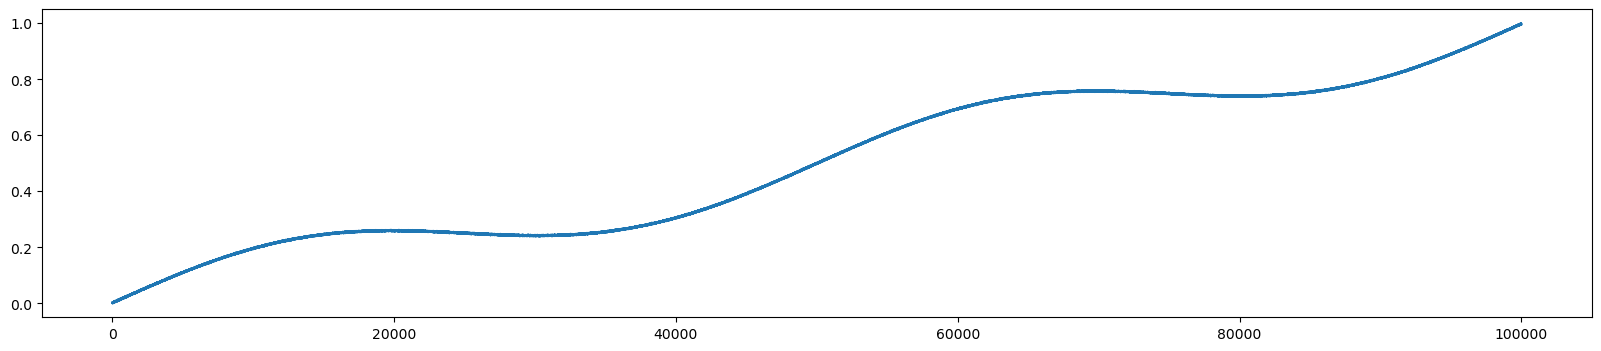

In [11]:
# Generate some sample data
def synthetic(N, freq=4, noise=0.2):
    length = np.pi * freq
    data = np.sin(np.linspace(0, length, N)) + 100.
    data += np.random.normal(0, noise, data.shape)
    data += np.linspace(0, 10, N)
    return data

data = synthetic(100_000, freq=4, noise=0.01)
data = data.reshape(-1, 1)

from sklearn.preprocessing import MinMaxScaler
# Normalizing
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Plotting the scaled data
plt.figure(figsize=(20, 4)) 
plt.plot(data)
plt.show()

In [12]:
# # generate some sample data
# data = np.sin(np.arange(0, 500_000, 1))

# # data = np.random.normal(np.arange(0, 100000, 1), 10000)
# # add some noise
# data += np.random.normal(0, .75, data.shape)
# data = np.expand_dims(data, axis=-1)
# print(data.shape)
# # plot with large size 
# plt.figure(figsize=(20, 4))
# plt.plot(data[:, 0])
# # Normalising
# # scale the data
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# data = scaler.fit_transform(data)
# plt.figure(figsize=(20, 4)) 
# plt.plot(data[:, 0])

In [13]:
X = data

In [14]:
timesteps = 128
features = 1
input_shape = (timesteps, features)
code_size = 32
batch_size = 16
train_index = int(0.7 * len(X))
forecast_horizon = 10

In [15]:
x_train = X[:train_index]
x_test = X[train_index:]

# y_train = x_train[timesteps::timesteps]
# y_test = x_test[timesteps::timesteps]

x_train = window(x_train, timesteps, strides=1) 
# x_train = window(x_train, timesteps, timesteps)
x_test = window(x_test, timesteps, strides=1)
# x_test = window(x_test, timesteps, timesteps)

y_train = np.zeros(len(x_train))
y_test = np.zeros(len(x_test))

for i in range(len(x_train)-1):
    # y_train[i] = np.sum(x_train[i+1, :forecast_horizon, 0])
    y_train[i] = np.log(x_train[i+1, forecast_horizon, 0] / x_train[i, -1, 0])
for i in range(len(x_test)-1):
    # y_test[i] = np.sum(x_test[i+1, :forecast_horizon, 0])
    y_test[i] = np.log(x_test[i+1, forecast_horizon, 0] / x_test[i, -1, 0])

y_test = np.where(y_test > 0, 1., 0)
y_train = np.where(y_train > 0, 1., 0)

print('Baseline: ', len(np.where(y_test > 0)[0]) / len(y_test))

# scale each window
for i in range(len(x_train)):
    x_train[i] = scale(x_train[i]) * 2. - 1.

for i in range(len(x_test)):
    x_test[i] = scale(x_test[i]) * 2. - 1.

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

assert(x_train.shape[0] == y_train.shape[0])
assert(np.isfinite(y_train).all() == True)
assert(np.isfinite(x_train).all() == True)
assert(np.isfinite(y_test).all() == True)
assert(np.isfinite(y_train).all() == True)

/var/folders/k0/x79hb9j52592z6fm_kpxykrr0000gn/T/ipykernel_64205/2364974529.py:17: RuntimeWarning: divide by zero encountered in log
  y_train[i] = np.log(x_train[i+1, forecast_horizon, 0] / x_train[i, -1, 0])


Baseline:  0.31146223888591323
(69872, 128, 1) (29872, 128, 1)
(69872,) (29872,)


# Data Generation

In [16]:
class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        # self.timesteps = timesteps
        self.data = data
        # self.data = self.window(data, timesteps, strides)
        self.indexes = np.arange(len(self.data) - 1)
        self.shuffle = shuffle
        self.on_epoch_end()
        
    # def window(self, data, timesteps, strides=1):
    #     x = []
    #     for i in range(0, len(data) - timesteps, strides):
    #         x.append(data[i:i+timesteps])
    #     return np.array(x)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.indexes) // self.batch_size

    def __getitem__(self, batch):
        'Generate one batch of data'
        x = []
        y = []
        labels = []
        
        indexes = self.indexes[batch*self.batch_size//2:(batch+1)*self.batch_size//2]

        for idx in indexes:
            x_positive = self.data[idx]
            y_positive = self.data[idx+1]
            
            y_negative = y_positive * -1.

            # v = np.random.choice(np.arange(3))

            # if v == 1:
            #     y_negative = self.data[np.random.choice(indexes)]
            # elif v == 2:
            #     # make y_negative normal distribution from same range as y_positive
            #     y_negative = np.random.lognormal(np.mean(x_positive), np.std(x_positive), x_positive.shape[0]) - 1.
            #     y_negative = np.clip(y_negative, -1.0, 1.0)
            #     y_negative = np.expand_dims(y_negative, -1)

            # positive sample
            x.append(x_positive)
            y.append(y_positive)
            labels.append(1)

            # negative sample
            x.append(x_positive)
            y.append(y_negative)
            labels.append(0)
        
        labels = np.expand_dims(np.array(labels), axis=-1)
        return (np.array(x), np.array(y)), labels

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [17]:
dg = DataGenerator(x_train, batch_size=16, shuffle=False)

print(len(dg))

# get the first batch
(x, y), labels = dg.__getitem__(0)
print(f"x shape: {x.shape}, y shape: {y.shape}, labels shape: {labels.shape}")

4366
x shape: (16, 128, 1), y shape: (16, 128, 1), labels shape: (16, 1)


# Inspecting Windows

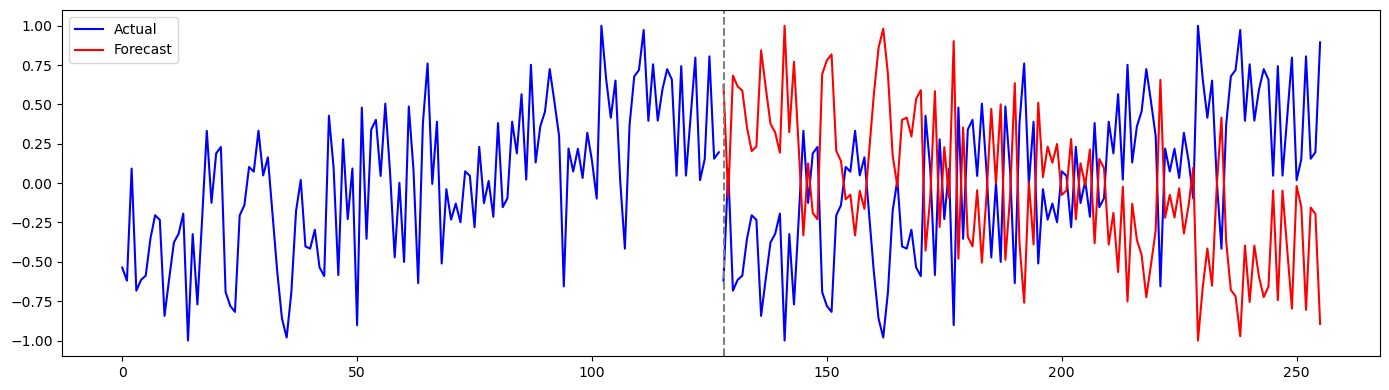

In [18]:
def plot_forecast(x, y, y_pred):
    t1 = np.arange(0, len(x), 1)
    t2 = np.arange(len(x), len(x) + len(y), 1)
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(t1, x, color='blue')
    ax.plot(t2, y, color='blue', label='Actual')
    ax.plot(t2, y_pred, color='red', label='Forecast')
    ax.axvline(x=len(x), color='gray', linestyle='--')
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_forecast(x[0, :, 0], y[0, :, 0], y[1, :, 0])
# plot_forecast(x[2, :, 0], y[2, :, 0], y[3, :, 0])

# V1

# Model Architecture

In [19]:
def build_encoder(input_shape, code_size):
    input = Input(shape=input_shape)
    x = Conv1D(128, 3, activation='relu', padding='same')(input)
    # x = BatchNormalization()(x)
    # x = Dropout(0.2)(x)
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = Dense(code_size, activation='linear', name='encoder_embedding')(x)
    return Model(input, x, name='encoder')

encoder = build_encoder((timesteps, features), code_size)
encoder.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 128, 128)          512       
                                                                 
 conv1d_1 (Conv1D)           (None, 128, 128)          49280     
                                                                 
 conv1d_2 (Conv1D)           (None, 128, 128)          49280     
                                                                 
 encoder_embedding (Dense)   (None, 128, 32)           4128      
                                                                 
Total params: 103,200
Trainable params: 103,200
Non-trainable params: 0
__________________________________________

In [20]:
def build_context(input_shape, code_size):
    '''Build the autoregressive model doing predictions'''
    input = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True, name="context")(input)
    # x = BatchNormalization()(x)
    # x = Dropout(0.2)(x)
    x = LSTM(128, return_sequences=True)(x)
    x = Dense(code_size, activation="linear", name="preds")(x)
    return Model(input, x, name="context")

context = build_context((timesteps, code_size), code_size)
context.summary()

Model: "context"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 32)]         0         
                                                                 
 context (LSTM)              (None, 128, 128)          82432     
                                                                 
 lstm (LSTM)                 (None, 128, 128)          131584    
                                                                 
 preds (Dense)               (None, 128, 32)           4128      
                                                                 
Total params: 218,144
Trainable params: 218,144
Non-trainable params: 0
_________________________________________________________________


In [21]:
# test classification naively 
# x_input = Input(input_shape, name='x_input')
# y_input = Input(input_shape, name='y_input')

# x = keras.layers.Concatenate(axis=1)([x_input, y_input])
# # x = y_input
# x = Conv1D(32, 3, activation='relu', padding='same')(x)
# x = LSTM(32, return_sequences=True)(x)
# x = Flatten()(x)
# x = Dense(32, activation='relu')(x)
# x = Dense(1, activation='sigmoid')(x)

# model = Model(inputs=[x_input, y_input], outputs=x, name='CPC')
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
# model.summary()

In [22]:
x_input = Input(input_shape)
encoded = encoder(x_input)
y_pred = context(encoded)

y_input = Input(input_shape)
y_encoded = encoder(y_input)

dot_product = K.sum(y_encoded * y_pred, axis=-1)
# dot_product = K.mean(y_encoded * y_pred, axis=-1)
dot_product = K.mean(dot_product, axis=-1, keepdims=True)  # along the temporal dimension

dot_product = K.sigmoid(dot_product)

model = Model(inputs=[x_input, y_input], outputs=dot_product, name='CPC')
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
model.summary()

Model: "CPC"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 1)]     0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 128, 1)]     0           []                               
                                                                                                  
 encoder (Functional)           (None, 128, 32)      103200      ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 context (Functional)           (None, 128, 32)      218144      ['encoder[0][0]']              

In [24]:
batch_size = 512
epochs = 5

train_gen = DataGenerator(x_train, batch_size=batch_size, shuffle=False)
test_gen = DataGenerator(x_test, batch_size=batch_size, shuffle=False)

In [25]:
history = model.fit(train_gen, batch_size=batch_size, epochs=epochs, validation_data=test_gen)

Epoch 1/5
136/136 [==============================] - 51s 362ms/step - loss: 0.1067 - binary_accuracy: 0.9666 - val_loss: 0.0015 - val_binary_accuracy: 0.9999
Epoch 2/5
136/136 [==============================] - 48s 354ms/step - loss: 8.5299e-04 - binary_accuracy: 0.9999 - val_loss: 6.3673e-04 - val_binary_accuracy: 1.0000
Epoch 3/5
136/136 [==============================] - 48s 353ms/step - loss: 4.1978e-04 - binary_accuracy: 0.9999 - val_loss: 2.0148e-04 - val_binary_accuracy: 1.0000
Epoch 4/5
136/136 [==============================] - 48s 351ms/step - loss: 3.3120e-04 - binary_accuracy: 0.9999 - val_loss: 1.0904e-04 - val_binary_accuracy: 1.0000
Epoch 5/5
136/136 [==============================] - 47s 347ms/step - loss: 1.2786e-04 - binary_accuracy: 1.0000 - val_loss: 3.6696e-04 - val_binary_accuracy: 1.0000


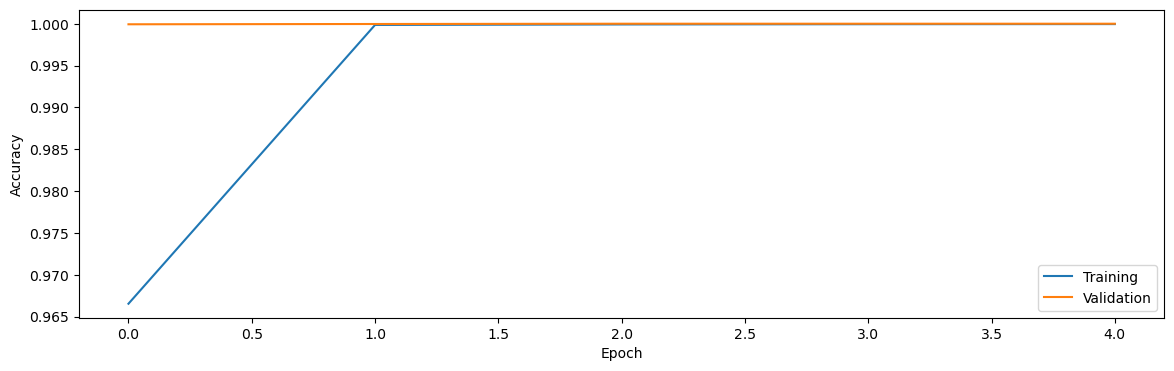

In [26]:
plot_training(history)

In [27]:
# get the best val accuracy from history
best_val_acc = max(history.history['val_binary_accuracy'])
print('Best validation accuracy: ', best_val_acc)

Best validation accuracy:  1.0


In [28]:
encoder.save('encoder_11_08.h5', include_optimizer=False)

In [39]:
# # compute embeddings in a rolling fashion for the entire time series 
# # WARNING: takes a while
# encoder = load_model('encoder.h5', compile=True)

# Xh = np.zeros((len(X) - timesteps, code_size))
# Yh = np.zeros((len(X) - timesteps))

# batch_size = 100000
# indexes = np.arange(len(X) - timesteps)
# batches = len(indexes) // batch_size

# for batch in range(batches):
#     print(int(batch / batches * 100))
#     idx = indexes[batch*batch_size:(batch+1)*batch_size]
#     embeddings = encoder.predict(np.array([ X[i:i+timesteps] for i in idx ]))

#     for i in idx:
#         Xh[i] = embeddings[i - idx[0], 0, :]
#         Yh[i] = np.sum(X[i:i+timesteps])

# np.save('embeddings.h5', Xh)

# print(Xh.shape, Yh.shape)

# V2

In [69]:
def build_encoder(input_shape, code_size):
    input = Input(shape=input_shape)
    x = Conv1D(128, 3, activation='relu', padding='same')(input)
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = Dense(code_size, activation='linear', name='encoder_embedding')(x)
    return Model(input, x, name='encoder')

encoder = build_encoder((timesteps, features), code_size)
encoder.summary()

def build_context(input_shape, code_size):
    '''Build the autoregressive model doing predictions'''
    input = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True, name="context")(input)
    # Use LSTM but only return the last hidden state (return_sequences=False)
    x = LSTM(128, return_sequences=False)(input)
    x = Dense(code_size, activation="linear", name="preds")(x)
    return Model(input, x, name="context")

context = build_context((timesteps, code_size), code_size)
context.summary()

x_input = Input(input_shape)
encoded = encoder(x_input)

y_pred = context(encoded)

y_input = Input((timesteps, features))
y_encoded = encoder(y_input)

y_encoded_context = context(y_encoded)

# Dot product between y_pred and y_encoded_contextualized
dot_product = K.sum(y_encoded_context * y_pred, axis=-1, keepdims=True)

# Apply sigmoid to the dot product
dot_product = K.sigmoid(dot_product)

model = Model(inputs=[x_input, y_input], outputs=dot_product, name='CPC')
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 128, 1)]          0         
                                                                 
 conv1d_15 (Conv1D)          (None, 128, 128)          512       
                                                                 
 conv1d_16 (Conv1D)          (None, 128, 128)          49280     
                                                                 
 conv1d_17 (Conv1D)          (None, 128, 128)          49280     
                                                                 
 encoder_embedding (Dense)   (None, 128, 32)           4128      
                                                                 
Total params: 103,200
Trainable params: 103,200
Non-trainable params: 0
_________________________________________________________________
Model: "context"
____________________________________

In [70]:
batch_size = 512
epochs = 50

train_gen = DataGenerator(x_train, batch_size=batch_size, shuffle=True)
test_gen = DataGenerator(x_test, batch_size=batch_size, shuffle=True)

In [71]:
history = model.fit(train_gen, batch_size=batch_size, epochs=epochs, validation_data=test_gen)

Epoch 1/50
136/136 [==============================] - 44s 306ms/step - loss: 0.0826 - binary_accuracy: 0.9642 - val_loss: 0.0086 - val_binary_accuracy: 0.9979
Epoch 2/50
 31/136 [=====>........................] - ETA: 28s - loss: 0.0050 - binary_accuracy: 0.9984

KeyboardInterrupt: 

In [72]:
plot_training(history)

NameError: name 'history' is not defined

In [44]:
# get the best val accuracy from history
best_val_acc = max(history.history['val_binary_accuracy'])
print('Best validation accuracy: ', best_val_acc)

Best validation accuracy:  0.7060546875


## Attention Mechanism

In [50]:

def build_encoder(input_shape, code_size):
    input = Input(shape=input_shape)
    x = Conv1D(128, 3, activation='relu', padding='same')(input)
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = Dense(code_size, activation='linear', name='encoder_embedding')(x)
    return Model(input, x, name='encoder')

encoder = build_encoder((timesteps, features), code_size)
encoder.summary()

def build_context(input_shape, code_size):
    '''Build the autoregressive model doing predictions'''
    input = Input(shape=input_shape)
    # LSTM now returns the entire sequence of hidden states
    x = LSTM(128, return_sequences=True, name="context")(input)
    x = LSTM(128, return_sequences=True, name="context")(input)
    x = Dense(code_size, activation="linear", name="preds")(x)
    return Model(input, x, name="context")

context = build_context((timesteps, code_size), code_size)
context.summary()

def attention_layer(encoded_seq, context_seq):
    # Compute the attention scores (dot product between encoded_seq and context_seq)
    attention_scores = Lambda(lambda x: K.batch_dot(x[0], x[1], axes=[2, 2]))([encoded_seq, context_seq])  # Shape: (batch_size, timesteps, timesteps)
    
    # Apply softmax to get the attention weights
    attention_weights = Softmax(axis=2, name="attention_weights")(attention_scores)  # Shape: (batch_size, timesteps, timesteps)
    
    # Multiply the attention weights with the encoded sequence to get the context vector
    context_vector_final = Lambda(lambda x: K.batch_dot(x[0], x[1]))([attention_weights, encoded_seq])  # Shape: (batch_size, timesteps, code_size)
    
    # Summing across the time dimension to get the final context vector
    context_vector_final = Lambda(lambda x: K.sum(x, axis=1))(context_vector_final)  # Shape: (batch_size, code_size)
    
    return context_vector_final

# Now building the full model
x_input = Input((timesteps, features))
encoded = encoder(x_input)

# Use the context model which now returns the entire sequence
context_seq = context(encoded)

y_input = Input((timesteps, features))
y_encoded = encoder(y_input)

# Apply the attention mechanism
attended_context = attention_layer(y_encoded, context_seq)

# Dot product between attended_context and context vector
dot_product = K.sum(attended_context * K.mean(context_seq, axis=1), axis=-1, keepdims=True)

# Apply sigmoid to the dot product
output = K.sigmoid(dot_product)

model = Model(inputs=[x_input, y_input], outputs=output, name='CPC')
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 128, 1)]          0         
                                                                 
 conv1d_21 (Conv1D)          (None, 128, 128)          512       
                                                                 
 conv1d_22 (Conv1D)          (None, 128, 128)          49280     
                                                                 
 conv1d_23 (Conv1D)          (None, 128, 128)          49280     
                                                                 
 encoder_embedding (Dense)   (None, 128, 32)           4128      
                                                                 
Total params: 103,200
Trainable params: 103,200
Non-trainable params: 0
_________________________________________________________________
Model: "context"
____________________________________

In [51]:
batch_size = 512
epochs = 50

train_gen = DataGenerator(x_train, batch_size=batch_size, shuffle=True)
test_gen = DataGenerator(x_test, batch_size=batch_size, shuffle=True)

In [52]:
history = model.fit(train_gen, batch_size=batch_size, epochs=epochs, validation_data=test_gen)

Epoch 1/50
5/5 [==============================] - 3s 378ms/step - loss: 0.7149 - binary_accuracy: 0.5012 - val_loss: 0.6987 - val_binary_accuracy: 0.5000
Epoch 2/50
5/5 [==============================] - 1s 260ms/step - loss: 0.6966 - binary_accuracy: 0.4984 - val_loss: 0.6945 - val_binary_accuracy: 0.5000
Epoch 3/50
5/5 [==============================] - 1s 258ms/step - loss: 0.6939 - binary_accuracy: 0.5023 - val_loss: 0.6928 - val_binary_accuracy: 0.4990
Epoch 4/50
5/5 [==============================] - 1s 257ms/step - loss: 0.6928 - binary_accuracy: 0.5102 - val_loss: 0.6931 - val_binary_accuracy: 0.5029
Epoch 5/50
5/5 [==============================] - 1s 259ms/step - loss: 0.6932 - binary_accuracy: 0.5027 - val_loss: 0.6933 - val_binary_accuracy: 0.5010
Epoch 6/50
5/5 [==============================] - ETA: 0s - loss: 0.6934 - binary_accuracy: 0.5090

KeyboardInterrupt: 

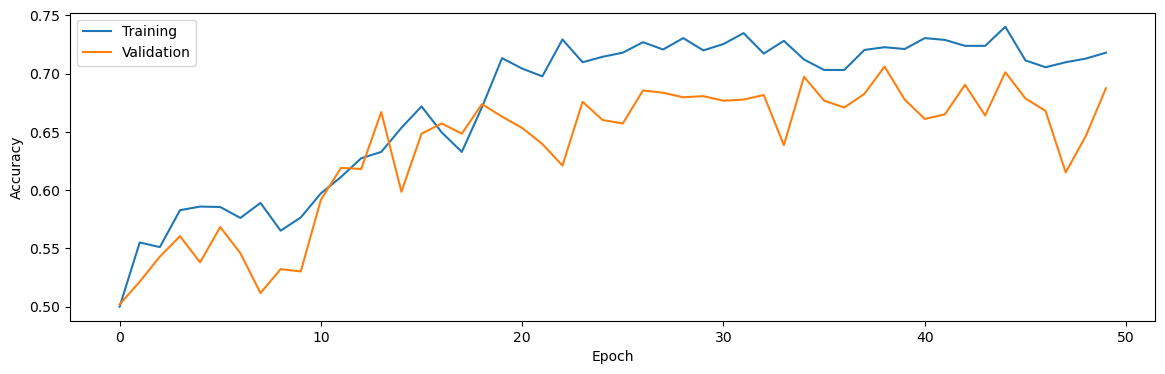

In [ ]:
plot_training(history)

In [204]:
def network_encoder(x, code_size):
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    # x = Conv1D(64, 3, activation='relu', padding='same')(x)
    # x = Dense(256, activation='linear')(x)
    # x = Dense(32, activation='linear')(x)
    x = Flatten()(x)
    x = Dense(code_size, activation='linear', name='encoder_embedding')(x)
    # x = Reshape((-1,1))(x)
    return x

In [205]:
encoder_input = Input(input_shape)
encoder_output = network_encoder(encoder_input, code_size)
encoder_model = Model(encoder_input, encoder_output, name='encoder')
encoder_model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_77 (InputLayer)       [(None, 128, 1)]          0         
                                                                 
 conv1d_41 (Conv1D)          (None, 128, 128)          512       
                                                                 
 batch_normalization_18 (Bat  (None, 128, 128)         512       
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 128, 128)          0         
                                                                 
 flatten_14 (Flatten)        (None, 16384)             0         
                                                                 
 encoder_embedding (Dense)   (None, 32)                524320    
                                                           

In [206]:
x_input = Input(input_shape)
x_encoded = encoder_model(x_input)

# integrates information along the sequence
x_encoded = (Reshape((-1,1))(x_encoded))
context = LSTM(128, return_sequences=False, name="context")(x_encoded)
context = BatchNormalization()(context)
# add drop out to context
context = Dropout(0.2)(context)

# predict z-latent from context
preds = Dense(code_size, activation="linear", name="preds")(context)

y_input = Input(input_shape)
y_encoded = encoder_model(y_input)

dot_product = K.sum(y_encoded * preds, axis=-1)
# dot_product = K.batch_dot(y_encoded, preds, axes=1)
dot_product = K.sigmoid(dot_product)

model = Model(inputs=[x_input, y_input], outputs=dot_product, name='contrastive')
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
model.summary()

Model: "contrastive"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_79 (InputLayer)          [(None, 128, 1)]     0           []                               
                                                                                                  
 input_78 (InputLayer)          [(None, 128, 1)]     0           []                               
                                                                                                  
 encoder (Functional)           (None, 32)           525344      ['input_78[0][0]',               
                                                                  'input_79[0][0]']               
                                                                                                  
 reshape_11 (Reshape)           (None, 32, 1)        0           ['encoder[0][0]']      

In [207]:
batch_size = 512
epochs = 50

train_gen = DataGenerator(x_train, batch_size=batch_size, shuffle=True)
test_gen = DataGenerator(x_test, batch_size=batch_size, shuffle=True)

model.fit(train_gen, batch_size=batch_size, epochs=epochs, validation_data=test_gen)

Epoch 1/50
5/5 [==============================] - 4s 261ms/step - loss: 2.9539 - binary_accuracy: 0.4961 - val_loss: 0.6927 - val_binary_accuracy: 0.5391
Epoch 2/50
5/5 [==============================] - 1s 108ms/step - loss: 2.3262 - binary_accuracy: 0.5238 - val_loss: 0.6918 - val_binary_accuracy: 0.5791
Epoch 3/50
5/5 [==============================] - 1s 106ms/step - loss: 1.9476 - binary_accuracy: 0.5512 - val_loss: 0.6909 - val_binary_accuracy: 0.5840
Epoch 4/50
5/5 [==============================] - 1s 106ms/step - loss: 1.7450 - binary_accuracy: 0.5484 - val_loss: 0.6899 - val_binary_accuracy: 0.5996
Epoch 5/50
5/5 [==============================] - 1s 104ms/step - loss: 1.3785 - binary_accuracy: 0.5957 - val_loss: 0.6877 - val_binary_accuracy: 0.6299
Epoch 6/50
5/5 [==============================] - 1s 103ms/step - loss: 1.1992 - binary_accuracy: 0.5918 - val_loss: 0.6843 - val_binary_accuracy: 0.6670
Epoch 7/50
5/5 [==============================] - 1s 103ms/step - loss: 0.96

# Downstream Task

In [32]:
# Custom loss function to maximize Sharpe ratio (negative Sharpe to minimize)
def sharpe_ratio_loss(y_true, y_pred):
    # y_pred represents the allocations
    # y_true represents the actual log returns
    # Portfolio returns
    returns = tf.multiply(y_pred, y_true)  # Element-wise multiplication
    mean_return = tf.reduce_mean(returns)
    std_return = tf.math.reduce_std(returns)
    
    # To prevent division by zero
    std_return = tf.where(tf.equal(std_return, 0), tf.constant(1e-10), std_return)
    
    # Sharpe ratio
    sharpe = mean_return / std_return
    
    # Since we want to maximize Sharpe, but Keras minimizes loss, return negative Sharpe
    return -sharpe

In [33]:
def build_forecasting(input_shape, encoder_file):
    encoder = load_model(encoder_file, compile=True)
    encoder.trainable = False  # Freeze the encoder model
    input = Input(input_shape)
    x = encoder(input)
    
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(128)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(input, x)

fm = build_forecasting(input_shape, 'encoder_11_08.h5')
fm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
fm.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 1)]          0         
                                                                 
 encoder (Functional)        (None, 128, 32)           103200    
                                                                 
 lstm_3 (LSTM)               (None, 128, 128)          82432     
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 333,857
Trainable params: 230,657
Non-trainab

In [34]:
checkpoint_callback = ModelCheckpoint(
    filepath='best_model_ds.h5',
    monitor='val_binary_accuracy',  # Monitor validation accuracy
    mode='max',  # Save the model when validation accuracy improves
    save_best_only=True,  # Save only the best model
    verbose=1  # Print messages when saving the model
)

history = fm.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/5
1092/1092 [==============================] - 46s 40ms/step - loss: 0.4165 - binary_accuracy: 0.8056 - val_loss: 0.4225 - val_binary_accuracy: 0.7942
Epoch 2/5
1092/1092 [==============================] - 42s 39ms/step - loss: 0.3699 - binary_accuracy: 0.8308 - val_loss: 0.4205 - val_binary_accuracy: 0.7971
Epoch 3/5
1092/1092 [==============================] - 42s 39ms/step - loss: 0.3582 - binary_accuracy: 0.8374 - val_loss: 0.3885 - val_binary_accuracy: 0.8107
Epoch 4/5
1092/1092 [==============================] - 42s 39ms/step - loss: 0.3378 - binary_accuracy: 0.8454 - val_loss: 0.3756 - val_binary_accuracy: 0.8204
Epoch 5/5
1092/1092 [==============================] - 43s 39ms/step - loss: 0.3321 - binary_accuracy: 0.8481 - val_loss: 0.3719 - val_binary_accuracy: 0.8202


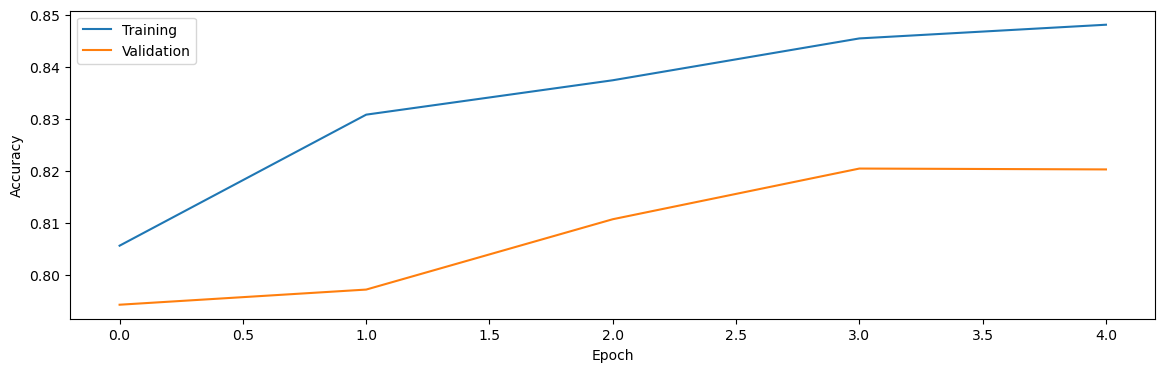

In [35]:
plot_training(history)

In [36]:
from sklearn.metrics import classification_report

y_pred = fm.predict(x_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

print(classification_report(y_test, y_pred))

934/934 [==============================] - 12s 12ms/step
              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88     20568
         1.0       0.77      0.61      0.68      9304

    accuracy                           0.82     29872
   macro avg       0.80      0.76      0.78     29872
weighted avg       0.82      0.82      0.81     29872



In [ ]:
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split

# Define the model architecture
def create_model(input_shape):
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='tanh')  # Output is in the range (-1, 1)
    ])
    return model

# Function to calculate Sharpe ratio
def sharpe_ratio(returns):
    mean_return = tf.reduce_mean(returns)
    std_return = tf.math.reduce_std(returns)
    sharpe = mean_return / std_return
    return sharpe

# Custom training loop with gradient ascent and current allocation as a feature
def train_model(model, features, log_returns, initial_allocation, epochs, learning_rate):
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    
    allocation = tf.convert_to_tensor(initial_allocation, dtype=tf.float32)
    
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            # Add the current allocation as a feature
            inputs = tf.concat([features, allocation], axis=1)
            new_allocation = model(inputs, training=True)  # Forward pass
            
            portfolio_returns = tf.reduce_sum(log_returns * new_allocation, axis=1)
            sharpe = sharpe_ratio(portfolio_returns)
            loss = -sharpe  # Negative Sharpe ratio (to maximize it)
        
        grads = tape.gradient(loss, model.trainable_variables)
        # optimizer.apply_gradients(zip([-g for g in grads], model.trainable_variables))
        optimizer.apply_gradients(zip(grads, model.trainable_variables))  # Apply gradients as-is for gradient ascent
        
        allocation = new_allocation  # Update the current allocation for the next time step
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss}, Sharpe Ratio: {sharpe:.4f}')
            print(f'Mean Portfolio Return: {tf.reduce_mean(portfolio_returns).numpy():.4f}')

# Simulated log returns and features for demonstration
np.random.seed(42)
# log_returns = np.random.randn(1000, 1)  # Example: 1000 time steps, 1 log return
log_returns = np.random.normal(0, 1.0, 1000)
features = np.random.randn(1000, 10)  # Example: 1000 time steps, 10 features

# Split the data into train and test sets
features_train, features_test, log_returns_train, log_returns_test = train_test_split(
    features, log_returns, test_size=0.2, random_state=42
)

# Initial allocation (e.g., start with zero allocation)
initial_allocation_train = np.zeros((features_train.shape[0], 1))
initial_allocation_test = np.zeros((features_test.shape[0], 1))

# Create the model with an input shape that includes both features and the current allocation
input_shape = features_train.shape[1] + 1  # +1 for the current allocation
model = create_model(input_shape)

# Train the model using the custom training loop
train_model(model, features_train, log_returns_train, initial_allocation_train, epochs=100, learning_rate=0.001)


Epoch 10/100, Loss: -1.2419993877410889, Sharpe Ratio: 1.2420
Mean Portfolio Return: 4.9709
Epoch 20/100, Loss: -4.460209369659424, Sharpe Ratio: 4.4602
Mean Portfolio Return: 12.6551
Epoch 30/100, Loss: -11.149535179138184, Sharpe Ratio: 11.1495
Mean Portfolio Return: 17.3924
Epoch 40/100, Loss: -49.54819869995117, Sharpe Ratio: 49.5482
Mean Portfolio Return: 19.9032
Epoch 50/100, Loss: -527.9171142578125, Sharpe Ratio: 527.9171
Mean Portfolio Return: 20.3466
Epoch 60/100, Loss: -15273.3779296875, Sharpe Ratio: 15273.3779
Mean Portfolio Return: 20.3721
Epoch 70/100, Loss: -1584566.875, Sharpe Ratio: 1584566.8750
Mean Portfolio Return: 20.3727
Epoch 80/100, Loss: -10575911.0, Sharpe Ratio: 10575911.0000
Mean Portfolio Return: 20.3727
Epoch 90/100, Loss: -10681147.0, Sharpe Ratio: 10681147.0000
Mean Portfolio Return: 20.3727
Epoch 100/100, Loss: -10681147.0, Sharpe Ratio: 10681147.0000
Mean Portfolio Return: 20.3727


In [ ]:

# Evaluate the model on the test set
current_allocations = initial_allocation_test
optimized_allocations = []

for t in range(features_test.shape[0]):
    inputs = np.concatenate([features_test[t:t+1], current_allocations[t:t+1]], axis=1)
    allocation = model.predict(inputs)
    optimized_allocations.append(allocation)
    current_allocations[t] = allocation  # Update the current allocation

optimized_allocations = np.array(optimized_allocations)[:, 0, 0]

# Calculate the Sharpe ratio on the test set
portfolio_returns_test = log_returns_test * optimized_allocations
sharpe_test = sharpe_ratio(portfolio_returns_test)
print(f'Test Set Sharpe Ratio: {sharpe_test.numpy():.4f}')

1/1 [==============================] - 0s 14ms/step
Test Set Sharpe Ratio: -0.0053


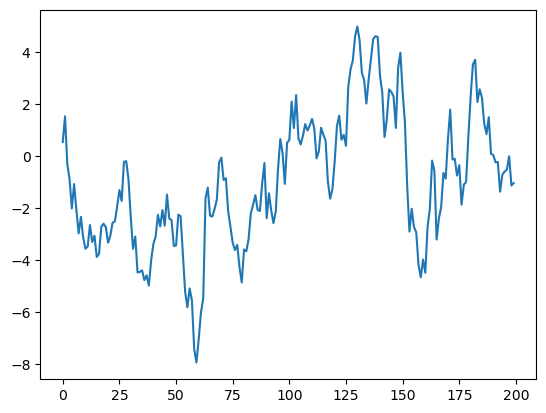

In [ ]:
plt.plot(np.cumsum(portfolio_returns_test))